In [136]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_score, pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score


In [108]:
def create_market_features(df):
    df['market_size'] = df['population'] * df['prev_perc']
    df['affordability_index'] = df['che_pc_usd'] / df['price_month']
    df['price_insurance_interaction'] = df['price_month'] * (1 - df['insurance_perc_che'])
    return df

In [111]:
train_df = pd.read_csv('../data/intermig/train_data-medianimputed.csv')
train_df = create_market_features(train_df)

train_df.replace('-1', np.nan, inplace=True)
train_df.replace(np.float64(-1.0), np.nan, inplace=True)
train_df['launch_date'] = pd.to_datetime(train_df['launch_date'], errors='coerce')
train_df['date'] = pd.to_datetime(train_df['date'], errors='coerce')
train_df = train_df.drop(columns=['ind_launch_date'])

submission_df = pd.read_csv('../data/intermig/submission_data-medianimputed.csv')
submission_df   = create_market_features(submission_df)
submission_df.replace('-1', np.nan, inplace=True)
submission_df.replace(np.float64(-1.0), np.nan, inplace=True)
submission_df['launch_date'] = pd.to_datetime(train_df['launch_date'], errors='coerce')
submission_df['date'] = pd.to_datetime(train_df['date'], errors='coerce')
submission_df = submission_df.drop(columns=['ind_launch_date'])


template_df = pd.read_csv('../data/processed/submission_template.csv')


In [112]:
all_ids = train_df.cluster_nl.unique()
rows_to_drop = []

for id in all_ids:
    sub_df = train_df[train_df.cluster_nl == id]  
    first_date = sub_df['date'].min()  
    cutoff_date = first_date + pd.DateOffset(months=12)  # 23 months a provar

    filtered_df = sub_df[sub_df['date'] <= cutoff_date]
    rows_to_drop.append(train_df[train_df.cluster_nl == id].index.difference(filtered_df.index))


rows_to_drop = np.concatenate(rows_to_drop)
train_df = train_df.drop(rows_to_drop)

In [114]:
train_df.head(2)

,brand,che_pc_usd,che_perc_gdp,cluster_nl,corporation,country,launch_date,date,drug_id,indication,...,prev_perc,price_month,price_unit,public_perc_che,therapeutic_area,target,months_since_launch,market_size,affordability_index,price_insurance_interaction
0,BRAND_354E,1.209114,1.665879,BRAND_354E_COUNTRY_88A3,CORP_D524,COUNTRY_88A3,2014-06-01,2014-06-01,DRUG_ID_8795,['IND_C3B6'],...,0.028367,1.006444,1.013784,1.835821,THER_AREA_980E,1.000784,0,0.028595,1.201372,-0.899090
1,BRAND_626D,1.296738,1.809198,BRAND_626D_COUNTRY_8B47,CORP_01C7,COUNTRY_8B47,2014-06-01,2014-06-01,DRUG_ID_E66E,"['IND_1590', 'IND_ECAC']",...,0.000047,1.092357,1.626677,1.791045,THER_AREA_96D7,1.000000,0,0.000048,1.187101,-0.502484


In [ ]:
def preprocess_data(train_df, aggregation_features):
    knn_imputer = KNNImputer(n_neighbors=5)
    knn_imputer.fit(train_df[aggregation_features])  
    complete_data_imputed = knn_imputer.transform(train_df[aggregation_features])
    scaler = StandardScaler()
    complete_data_scaled = scaler.fit_transform(complete_data_imputed)
    print('preprocess_data done')
    return knn_imputer, scaler, complete_data_scaled

def evaluate_kmeans(X, max_clusters=4):
    silhouette_scores = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_)) 
    
    optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2
    return optimal_clusters_silhouette

def create_clusters(X, optimal_clusters_silhouette):
    kmeans = KMeans(n_clusters=optimal_clusters_silhouette, random_state=42)
    clusters = kmeans.fit_predict(X)
    print('create_clusters finished')
    return kmeans, clusters

def preprocess_submission_data(submission_df, knn_imputer, aggregation_features):
    submission_imputed = knn_imputer.transform(submission_df[aggregation_features])
    submission_imputed_df = pd.DataFrame(submission_imputed, columns=aggregation_features)
    return submission_imputed_df

def assign_clusters_to_submission(submission_df, submission_imputed_df, kmeans, scaler):
    submission_scaled = scaler.transform(submission_imputed_df)
    distances_submission = pairwise_distances(submission_scaled, kmeans.cluster_centers_)
    submission_df.loc[:, 'cluster'] = np.argmin(distances_submission, axis=1)
    print('assign_clusters_to_submission finished')
    return submission_df

def process_data(train_df, submission_df, aggregation_features):
    knn_imputer, scaler, complete_data_scaled = preprocess_data(train_df, aggregation_features)
    optimal_clusters_silhouette = evaluate_kmeans(complete_data_scaled)
    kmeans, complete_data_clusters = create_clusters(complete_data_scaled, optimal_clusters_silhouette)
    train_df['cluster'] = complete_data_clusters
    submission_imputed_df = preprocess_submission_data(submission_df, knn_imputer, aggregation_features)
    submission_with_clusters = assign_clusters_to_submission(submission_df, submission_imputed_df, kmeans, scaler)
    print('process data finished')
    return train_df, submission_with_clusters, kmeans



aggregation_features = train_df.select_dtypes(include=['number']).columns.tolist()
train_df_with_clusters, submission_df_with_clusters, kmeans_model = process_data(train_df, submission_df, aggregation_features)

preprocess_data done
create_clusters finished
assign_clusters_to_submission finished
process data finished


c:\anaconda3\envs\novartis\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


NameError: name 'PCA' is not defined

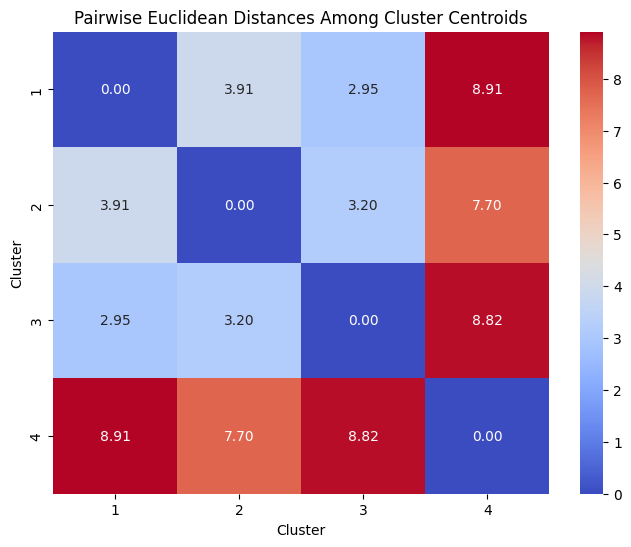

In [125]:
from sklearn.metrics import pairwise_distances
kmeans_model.cluster_centers_
# Get centroids
centroids = kmeans_model.cluster_centers_

# Calculate pairwise distances between centroids
distances = pairwise_distances(centroids, metric='euclidean')

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(distances, annot=True, cmap='coolwarm', xticklabels=np.arange(1, len(centroids)+1),
            yticklabels=np.arange(1, len(centroids)+1), fmt='.2f')
plt.title('Pairwise Euclidean Distances Among Cluster Centroids')
plt.xlabel('Cluster')
plt.ylabel('Cluster')
plt.show()

<Axes: >

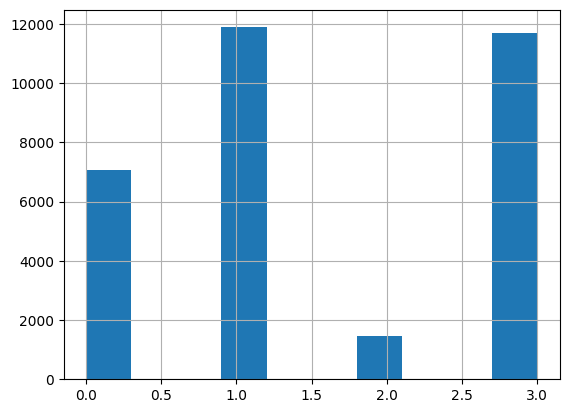

In [116]:
train_df_with_clusters.cluster.hist()

<Axes: >

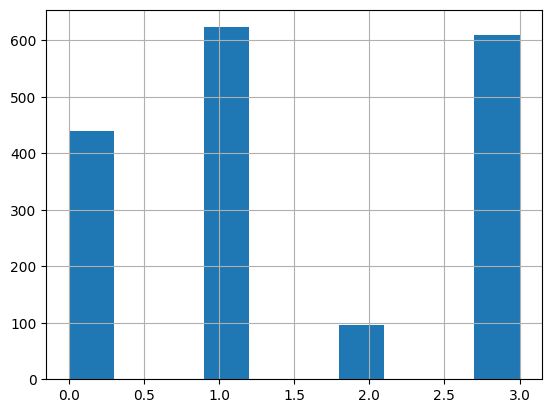

In [117]:
submission_df_with_clusters.cluster.hist()

In [126]:
train_df_s, test_df_s = train_test_split(train_df_with_clusters, test_size=0.15, random_state=42)

In [127]:
def preprocess_data_with_dates(train_df, target_column='target', cluster_column='cluster'):
  

    X = train_df.drop(columns=[target_column, cluster_column])
    y = train_df[target_column]
    date_columns = ['date', 'launch_date', 'ind_launch_date']
    
    for col in date_columns:
        if col in X.columns:

            X[col] = pd.to_datetime(X[col], errors='coerce')
            
            # Extract date features
            X[col + '_year'] = X[col].dt.year.fillna(0).astype(int)  # Fill missing years with 0
            X[col + '_month'] = X[col].dt.month.fillna(0).astype(int)
            X[col + '_day'] = X[col].dt.day.fillna(0).astype(int)
            X[col + '_dayofweek'] = X[col].dt.dayofweek.fillna(0).astype(int)
            X[col + '_dayofyear'] = X[col].dt.dayofyear.fillna(0).astype(int)
            X[col + '_is_month_start'] = X[col].dt.is_month_start.fillna(False).astype(int)
            X[col + '_is_month_end'] = X[col].dt.is_month_end.fillna(False).astype(int)
            X[col + '_is_quarter_start'] = X[col].dt.is_quarter_start.fillna(False).astype(int)
            X[col + '_is_quarter_end'] = X[col].dt.is_quarter_end.fillna(False).astype(int)
            X[col + '_is_year_start'] = X[col].dt.is_year_start.fillna(False).astype(int)
            X[col + '_is_year_end'] = X[col].dt.is_year_end.fillna(False).astype(int)

            X = X.drop(columns=[col])
    
    X = X.fillna(0) 

    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

    return X, y, numeric_cols, categorical_cols

In [130]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_xgboost_model(
    name, 
    train_df, 
    target_column='target', 
    cluster_column='cluster', #revisar.
    save_model_path='best_xgboost_model.pkl', 
    mape_scorer=''
):
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    save_model_path = f'../data/models/{name}.pkl'
    X, y, numeric_cols, categorical_cols = preprocess_data_with_dates(train_df, target_column, cluster_column)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),  
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols) 
        ])
    
    model = xgb.XGBRegressor(objective='reg:absoluteerror', random_state=42)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    param_grid = {
        'model__n_estimators': [100, 300],  
        'model__learning_rate': [0.01, 0.05], 
        'model__max_depth': [3,  10],  
        'model__subsample': [1.0], 
        'model__colsample_bytree': [0.8, 1.0],  
        'model__min_child_weight': [1, 5],  
        'model__gamma': [0, 1],   
    }
    
    """
        param_grid = {
            'model__n_estimators': [100, 300, 500],  
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2], 
            'model__max_depth': [3, 5, 10],  
            'model__subsample': [0.8, 1.0], 
            'model__colsample_bytree': [0.8, 1.0],  
            'model__min_child_weight': [1, 3, 5],  
            'model__gamma': [0, 1],   
        }
    """
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=3, 
        scoring=mape_scorer, 
        n_jobs=-1, 
        verbose=1
    )
    
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, save_model_path)
    
    return best_model

In [ ]:
name_list = ['zero_v2','one_v2','two_v2','three_v2','four','five','six','seven','eight']
for i in range(4): # int in range must be n_clusters
    best_model = train_xgboost_model(name_list[i],train_df=train_df_s[train_df_s.cluster==i])
    print(f'xgboost for cluster {i} completed.')

Fitting 3 folds for each of 64 candidates, totalling 192 fits
xgboost for cluster 0 completed.
Fitting 3 folds for each of 64 candidates, totalling 192 fits
xgboost for cluster 1 completed.
Fitting 3 folds for each of 64 candidates, totalling 192 fits
xgboost for cluster 2 completed.
Fitting 3 folds for each of 64 candidates, totalling 192 fits
xgboost for cluster 3 completed.


In [156]:
#X_test, y_test, _, _=preprocess_data_with_dates(test_df_s, target_column='target', cluster_column='cluster')

for i in range(4):
    sub_X_test = test_df_s[test_df_s.cluster==i]
    X_test, y_test, _, _=preprocess_data_with_dates(sub_X_test, target_column='target', cluster_column='cluster')
    if i==2:
        loaded_model_1 = joblib.load(('../data/models/'+name_list[sub_X_test.cluster.values[0].astype(int)]+'.pkl'))
        loaded_model_2 = joblib.load(('../data/models/'+name_list[sub_X_test.cluster.values[1].astype(int)]+'.pkl'))
        y_pred_1 = loaded_model_1.predict(X_test)
        y_pred_2 = loaded_model_2.predict(X_test)
        y_pred = np.mean([y_pred_1, y_pred_2], axis=0)
        r2 = r2_score(y_test, y_pred)
    else:
        loaded_model = joblib.load(('../data/models/'+name_list[sub_X_test.cluster.values[0].astype(int)]+'.pkl'))
        y_pred = loaded_model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'For cluster {i}, r2={r2},mape={mape}.')
    

For cluster 0, r2=0.7863855470554382,mape=5.637274384358538.
For cluster 1, r2=0.7530325093499037,mape=2.024695777795357.
For cluster 2, r2=0.6790215256817318,mape=2.024695777795357.
For cluster 3, r2=0.8414765795238118,mape=4.727783787071082.


In [155]:
all_y_true

[np.float64(1.004422141725428),
 np.float64(1.0871499569866645),
 np.float64(1.0040990500491738),
 np.float64(3.482824165541036),
 np.float64(1.1732782802144224),
 np.float64(1.2395439999015143),
 np.float64(1.1842595629649928),
 np.float64(1.056709102097838),
 np.float64(2.083043397929361),
 np.float64(1.0559477295390127),
 np.float64(1.00869103838702),
 np.float64(1.3598699097760487),
 np.float64(1.017030890169416),
 np.float64(11.011976612555651),
 np.float64(1.4895331833540917),
 np.float64(1.563774542388529),
 np.float64(1.1806506448271334),
 np.float64(3.698718110149177),
 np.float64(1.5465928410124854),
 np.float64(1.5185733663657264),
 np.float64(1.0865060723101136),
 np.float64(1.023341777306623),
 np.float64(2.0890309379818746),
 np.float64(2.258984566536374),
 np.float64(1.45849875925134),
 np.float64(1.736033487520002),
 np.float64(2.660912144247329),
 np.float64(1.1223408916713278),
 np.float64(1.734928846018184),
 np.float64(1.018371018252662),
 np.float64(1.6184767752058

In [56]:
s_df = submission_df_with_clusters.copy()
submission_array = np.zeros([len(template_df)])
for i,row in template_df.iterrows():
    X = s_df[(s_df.date==row.iloc[0])&(s_df.cluster_nl==row.iloc[1])].head()
    loaded_model = joblib.load(('../data/models/'+name_list[X.cluster.values[0].astype(int)]+'.pkl'))
    X_test,_,_,_ = preprocess_data_with_dates(X, target_column='target', cluster_column='cluster')
    submission_array[i] = loaded_model.predict(X_test).item()
template_df.prediction = submission_array

In [57]:
template_df.to_csv('../data/outputs/try3_RR.csv',index=False)

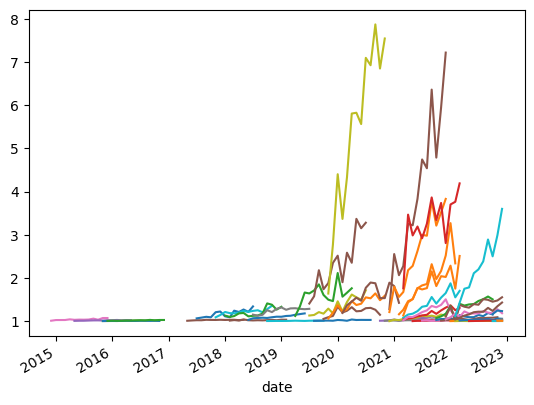

In [142]:
brands = train_df_with_clusters.cluster_nl.unique()
for id in brands:
    ts=train_df_with_clusters[(train_df_with_clusters.cluster == 3)&(train_df_with_clusters.cluster_nl == id)]
    ts = ts.set_index('date')
    ts.target.plot()

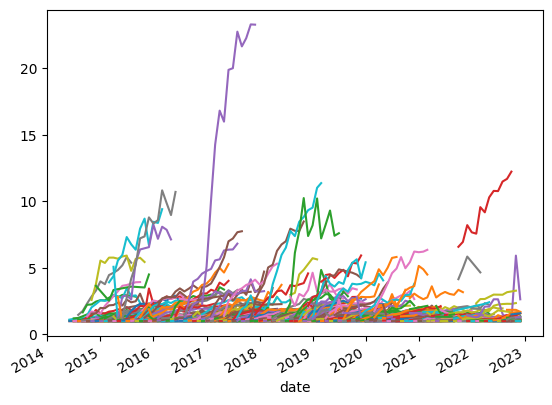

In [105]:
brands = train_df_with_clusters.cluster_nl.unique()
for id in brands:
    ts=train_df_with_clusters[(train_df_with_clusters.cluster == 0)&(train_df_with_clusters.cluster_nl == id)]
    ts = ts.set_index('date')
    ts.target.plot()